In [1]:
import dask

dask.config.set({"dataframe.query-planning": False})

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

import sys
sys.path.append("../../workflow/scripts/")
import readwrite
cfg = readwrite.config()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:504: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:505: FutureWarning: functools.partial will be a method descriptor in future Python versions; wra

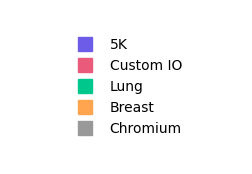

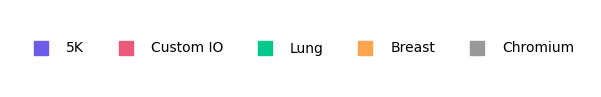

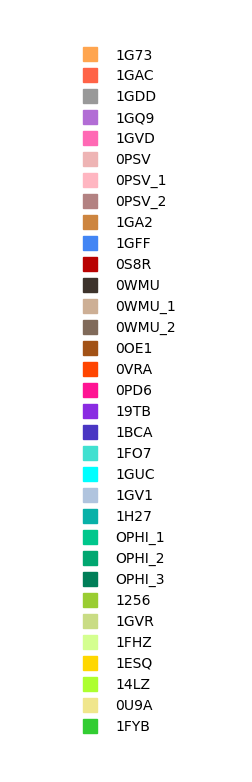

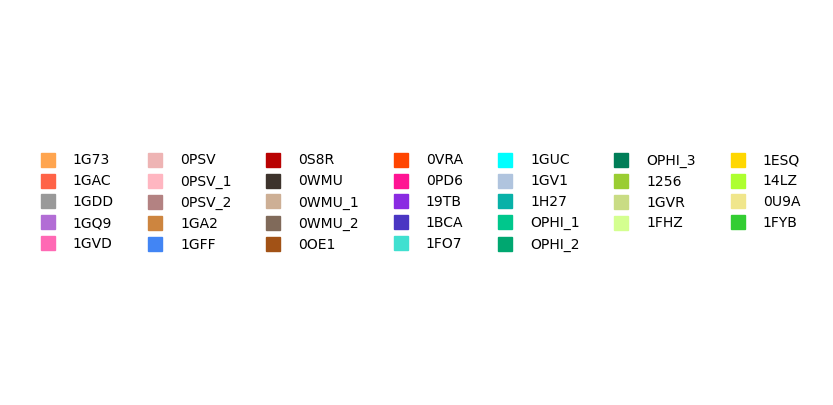

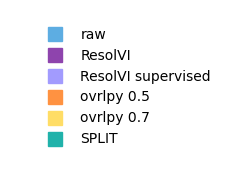

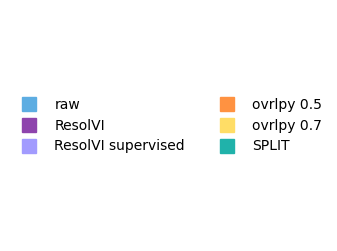

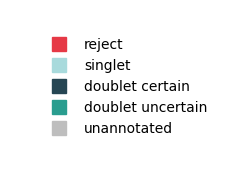

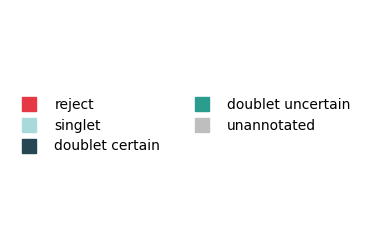

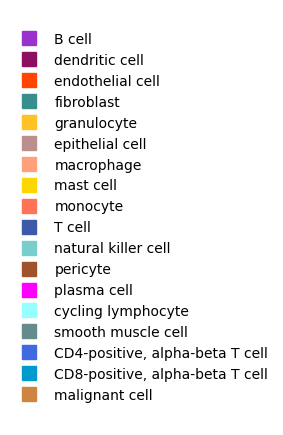

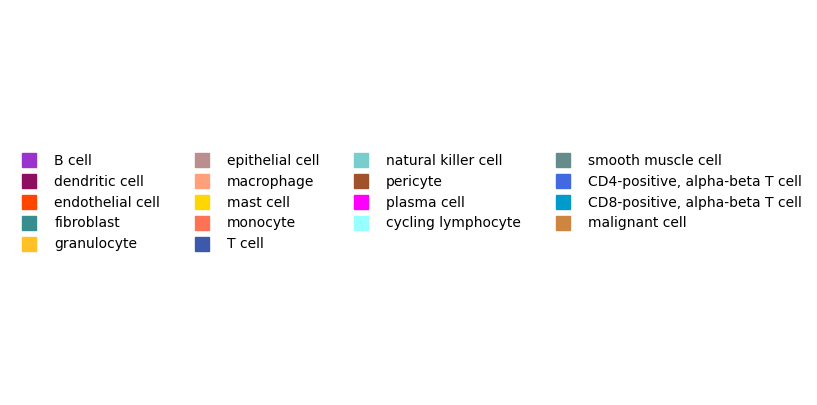

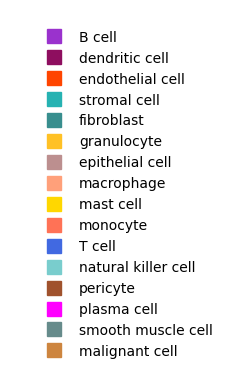

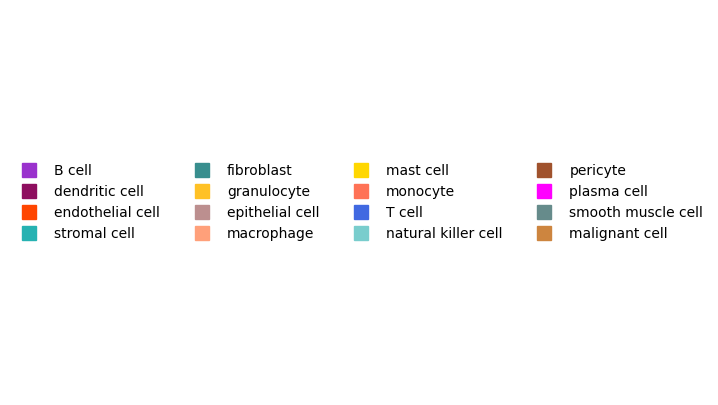

Finished generating legends.


In [3]:
output_folder = Path(cfg['figures_dir']) / 'palettes'
palettes_dir = cfg['xenium_metadata_dir'] # This seems unused, but kept from original
panel_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_panel.csv')
sample_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_sample.csv')
count_correction_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_correction_method.csv')
spot_class_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_spot_class.csv')
cell_type_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_cell_types_combo.csv')


dpi = 300
output_folder.mkdir(parents=True, exist_ok=True) # Create output dir once

for color in ['panel', 'sample', 'count_correction', 'spot_class', 'Level2.1', 'Level2_external']:

    palette = None # Initialize palette
    palette_file = None # Initialize palette_file

    if color in ["panel", "sample", "count_correction", "spot_class"]:
        if color == "panel":
            palette_file = panel_palette
        if color == "sample":
            palette_file = sample_palette
        elif color == "count_correction":
            palette_file = count_correction_palette
        elif color == "spot_class":
            palette_file = spot_class_palette

        if palette_file.exists():
            palette = pd.read_csv(palette_file, index_col=0).iloc[:, 0]

    elif color == "Level2.1":
        palette_file = cell_type_palette
        if palette_file.exists():
            palette_df = pd.read_csv(cell_type_palette)

            palette_lvl2 = palette_df[["Level2", "cols_Level2"]]
            palette_lvl2 = palette_lvl2.drop_duplicates().set_index("Level2").squeeze()

            palette = palette_df[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()
            palette = palette[~palette.index.astype(str).str.contains("malignant")] 

            for k, v in palette_lvl2.items():
                if k not in palette.index:
                    palette.loc[k] = palette_lvl2[k]

            palette = palette.reset_index()
            palette[color] = palette[color].astype(str).replace(r" of .+", "", regex=True) 
            palette = palette.drop_duplicates().set_index(color).squeeze()

            palette = palette.drop(['glial cell','stromal cell','myeloid cell'])

    elif color == "Level2_external":
        palette_file = cell_type_palette
        if palette_file.exists():
            palette_df = pd.read_csv(cell_type_palette)

            palette = palette_df[["Level2", "cols_Level2"]].drop_duplicates()
            palette["Level2"] = palette["Level2"].astype(str).replace(r" of .+", "", regex=True) 
            palette = palette.drop_duplicates().set_index("Level2").squeeze()
            palette = palette.drop(['glial cell', 'cycling lymphocyte', 'myeloid cell'])

    else:
         # General case if more colors are added later, assuming structure consistency
         palette_file = cell_type_palette
         if palette_file.exists() and color in pd.read_csv(palette_file).columns:
            palette = pd.read_csv(cell_type_palette)[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()


    if palette is None or palette.empty:
        print(f"Warning: Palette for '{color}' could not be loaded or is empty. Skipping.")
        continue
    if palette_file is None:
        print(f"Warning: palette_file not set for '{color}'. Skipping.")
        continue

    # Create square legend handles
    handles = [mlines.Line2D([], [], color=v, marker='s', linestyle='None',
                         markersize=10, label=k) for k, v in palette.items()]

    # --- VERTICAL LEGEND ---
    output_file_v = output_folder / f"{palette_file.stem}_{color}_legend_vertical.png"
    fig_v, ax_v = plt.subplots(figsize=(3, max(2, len(handles) * 0.3))) # Adjust height slightly based on items
    ax_v.legend(handles=handles, loc='center', frameon=False)
    ax_v.axis('off')
    plt.savefig(output_file_v, bbox_inches='tight', dpi=dpi)
    plt.show()
    plt.close(fig_v) # Close the figure


    # --- HORIZONTAL LEGEND (5 ROWS) ---
    if color == 'panel':
        rows = 1
    elif color in ['count_correction', 'spot_class']:
        rows = 3
    else: 
        rows = 5
    output_file_h = output_folder / f"{palette_file.stem}_{color}_legend_horizontal.png"
    num_items = len(handles)
    # Calculate number of columns needed to approximate 5 rows
    ncols = np.ceil(num_items / rows)
    # Adjust figure size - width based on columns, height fixed or slightly adjusted
    fig_h, ax_h = plt.subplots(figsize=(max(rows, ncols * 1.5), rows)) # Adjust width based on cols, fixed height
    ax_h.legend(handles=handles, loc='center', frameon=False, ncol=ncols)
    ax_h.axis('off')
    plt.savefig(output_file_h, bbox_inches='tight', dpi=dpi)
    plt.show()
    plt.close(fig_h) # Close the figure

print("Finished generating legends.")

In [21]:
df = pd.read_parquet('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/seurat_to_h5/external_lung/metadata.parquet')
df['Level2'].unique()

array(['macrophage', 'monocyte', 'malignant cell of lung', 'T cell',
       'B cell', 'natural killer cell', 'endothelial cell',
       'fibroblast of lung', 'epithelial cell of lung', 'dendritic cell',
       'plasma cell', 'mast cell', 'myeloid cell', 'smooth muscle cell',
       'pericyte', 'granulocyte', 'stromal cell'], dtype=object)